In [2]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
%matplotlib notebook

# Problem 1

Complete the function `poisson_square` by implementing the finite difference method given in the lab. Use `scipy.sparse.linalg.spsolve` to solve the linear system. Use your function to solve the boundary value problem:

\begin{align}
	\begin{split}
	\Delta u = 0, &{}\quad x \in [0,1]\times [0,1],\\
	u(x,y) = x^3, &{}\quad (x,y) \in \partial ([0,1]\times [0,1]).
	\end{split}
	\label{poisson2d:laplace}
\end{align}

Use $n=100$ subintervals for both $x$ and $y$. Plot the solution as a 3D surface.

<IPython.core.display.Javascript object>


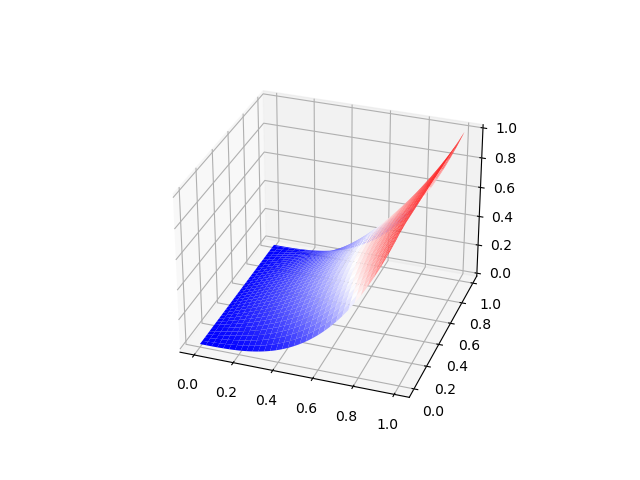

In [56]:
def poisson_square(a,b,c,d,f,g,n):
    """Computes the finite difference method for the Poisson equation boundary-value
    problem on a square:
        
        u_xx + u_yy = f on R = [a,b]×[c,d]
        u = g on ∂R
    
    where (b-a) = (d-c).
        
    Parameters:
        a (float): left-hand boundary for x
        b (float): right-hand boundary for x
        c (float): lower boundary for y
        d (float): upper boundary for y
        f (function): right-hand side of the PDE
        g (function): boundary condition
        n (int): number of subintervals
    Returns:
        U (ndarray of shape (n+1,n+1)): approximate solution
    """
    x = np.linspace(a, b, n+1)
    y = np.linspace(c, d, n+1)
    h = x[1] - x[0]
    
    # Create A (n-1)^2 x (n-1)^2
    T_diagonals = [[1 for i in range(n-2)],
                   [-4 for i in range(n-1)],
                   [1 for i in range(n-2)]]
    T = sp.diags(T_diagonals, [-1, 0, 1])
    A = sp.block_diag((T for i in range(n-1)))
    I = sp.diags([1,1], [-(n-1),n-1], shape=(A.shape))
    A = A + I
    A = 1/(h**2) * A
    
    # Create p (n-1)^2 x 1
    ps = []
    for j in range(1,n):
        p = np.zeros(n-1)
        p[0] = g(x[0], y[j])
        p[-1] = g(x[n], y[j])
        ps.append(p)
    p = 1/(h**2) * np.array([i for p in ps for i in p])
    
    # Create q
    q1 = [g(x[j], y[0]) for j in range(1, n)]
    qn_1 = [g(x[j], y[n]) for j in range(1, n)]
    q_j = np.array([np.zeros(n-1) for j in range(2, n-1)]).flatten().tolist()
    q = q1 + q_j + qn_1
    q = 1/(h**2) * np.array(q)

    fs = np.array([f(x[i], y[j]) for j in range(1, n) for i in range(1, n)])
    
    U = sp.linalg.spsolve(A, fs-p-q).reshape((n-1, n-1))
    big_U = np.zeros((n+1, n+1))
    big_U[1:-1, 1:-1] = U
    big_U[0] = [f(xx, y[0]) for xx in x]
    big_U[-1] = [f(xx, y[-1]) for xx in x]
    big_U[:,0] = [f(x[0], yy) for yy in y]
    big_U[:,-1] = [f(x[-1], yy) for yy in y]
    
    return big_U


a = 0
b = 1
c = 0
d = 1
f = lambda x, y: x**3
g = lambda x, y: x**3
n = 100
ans = poisson_square(a,b,c,d,f,g,n)

fig = plt.figure()
ax = plt.axes(projection='3d')
x = np.linspace(a, b, n+1)
y = np.linspace(c, d, n+1)

X, Y = np.meshgrid(x, y)
ax.plot_surface(X, Y, ans, cmap='bwr')

# Problem 2

Solve 

\begin{align}
	\begin{split}
	\Delta V = -\rho(x,y), &{}\quad x \in [-2,2]\times [-2,2],\\
	u(x,y) = 0, &{}\quad (x,y) \in \partial ([-2,2]\times [-2,2]).
	\end{split}
	\label{poisson2d:source}
\end{align}

for the electric potential $V.$ Use the source function defined above, such that $\rho(x,y) = \text{source}(x,y)$. Use $n=100$ subintervals for $x$ and $y$. Use the provided code to plot your solution.

<IPython.core.display.Javascript object>


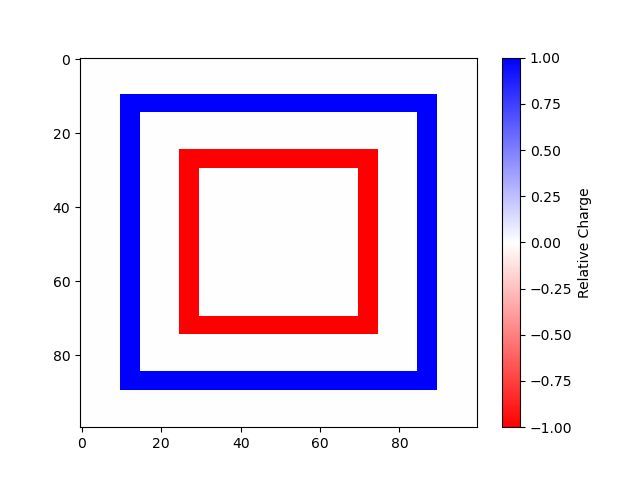

In [62]:
import matplotlib.colors as mcolors

def source(X,Y):
    """
    Takes arbitrary arrays of coordinates X and Y and returns an array of the same shape
    representing the charge density of nested charged squares
    """
    src = np.zeros(X.shape)
    src[ np.logical_or(np.logical_and( np.logical_or(abs(X-1.5) < .1,abs(X+1.5) < .1) ,abs(Y) <  1.6),
    np.logical_and( np.logical_or(abs(Y-1.5) < .1,abs(Y+1.5) < .1) ,abs(X) <  1.6))] = 1
    
    src[ np.logical_or(np.logical_and( np.logical_or(abs(X-0.9) < .1,abs(X+0.9) < .1) ,abs(Y) <  1.0),
    np.logical_and( np.logical_or(abs(Y-0.9) < .1,abs(Y+0.9) < .1) ,abs(X) <  1.0))] = -1
    return src
    
#Generate a color dictionary for use with LinearSegmentedColormap
#that places red and blue at the min and max values of data
#and white when data is zero
def genDict(data):
    zero = 1/(1 - np.max(data)/np.min(data))
    cdict = {
    'red': [(0.0, 1.0, 1.0),(zero, 1.0, 1.0),(1.0, 0.0, 0.0)],
    'green': [(0.0, 0.0, 0.0),(zero, 1.0, 1.0),(1.0, 0.0, 0.0)],
    'blue': [(0.0, 0.0, 0.0),(zero, 1.0, 1.0),(1.0, 1.0, 1.0)]
    }
    return cdict

a1 = -2.
b1 = 2.
c1 = -2.
d1 = 2.
n = 100
X = np.linspace(a1,b1,n)
Y = np.linspace(c1,d1,n)
X,Y = np.meshgrid(X,Y)

fig = plt.figure()
plt.imshow(source(X,Y),cmap = mcolors.LinearSegmentedColormap('cmap', genDict(source(X,Y))), aspect='auto')
plt.colorbar(label="Relative Charge")
plt.show()

<IPython.core.display.Javascript object>


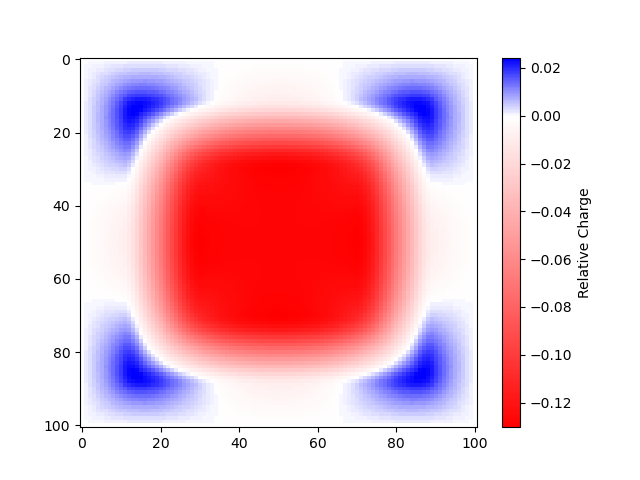

In [66]:
a = -2
b = 2
c = -2
d = 2
f = source
g = lambda x, y: 0
n = 100

ans = poisson_square(a,b,c,d,f,g,n)

X = np.linspace(a1,b1,n)
Y = np.linspace(c1,d1,n)
X,Y = np.meshgrid(X,Y)

fig = plt.figure()
plt.imshow(-ans,cmap = mcolors.LinearSegmentedColormap('cmap', genDict(-ans)), aspect='auto')
plt.colorbar(label="Relative Charge")
plt.show()